In [1]:

#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath

In [2]:
import torchvision.transforms as transforms

In [31]:
import numpy as np
import torch


class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.

    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)

    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.

    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.

            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask



In [32]:
import numpy as np
import torch


def tensor_to_complex_np(data):
    """
    Converts a complex torch tensor to numpy array.
    Args:
        data (torch.Tensor): Input data to be converted to numpy.
    Returns:
        np.array: Complex numpy version of data
    """
    data = data.numpy()
    return data[..., 0] + 1j * data[..., 1]


def to_tensor(data):
    """
    Convert numpy array to PyTorch tensor. For complex arrays, the real and imaginary parts
    are stacked along the last dimension.

    Args:
        data (np.array): Input numpy array

    Returns:
        torch.Tensor: PyTorch version of data
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)
    return torch.from_numpy(data)


def apply_mask(data, mask_func, seed=None):
    """
    Subsample given k-space by multiplying with a mask.

    Args:
        data (torch.Tensor): The input k-space data. This should have at least 3 dimensions, where
            dimensions -3 and -2 are the spatial dimensions, and the final dimension has size
            2 (for complex values).
        mask_func (callable): A function that takes a shape (tuple of ints) and a random
            number seed and returns a mask.
        seed (int or 1-d array_like, optional): Seed for the random number generator.

    Returns:
        (tuple): tuple containing:
            masked data (torch.Tensor): Subsampled k-space data
            mask (torch.Tensor): The generated mask
    """
    shape = np.array(data.shape)
    shape[:-3] = 1
    mask = mask_func(shape, seed)
    return torch.where(mask == 0, torch.Tensor([0]), data), mask


def fft2(data):
    """
    Apply centered 2 dimensional Fast Fourier Transform.

    Args:
        data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -3 & -2 are spatial dimensions and dimension -1 has size 2. All other dimensions are
            assumed to be batch dimensions.

    Returns:
        torch.Tensor: The FFT of the input.
    """
   # assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = torch.fft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def ifft2(data):
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.

    Args:
        data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -3 & -2 are spatial dimensions and dimension -1 has size 2. All other dimensions are
            assumed to be batch dimensions.

    Returns:
        torch.Tensor: The IFFT of the input.
    """
    #assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = torch.ifft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def complex_abs(data):
    """
    Compute the absolute value of a complex valued input tensor.

    Args:
        data (torch.Tensor): A complex valued tensor, where the size of the final dimension
            should be 2.

    Returns:
        torch.Tensor: Absolute value of data
    """
   # assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1).sqrt()


def root_sum_of_squares(data, dim=0):
    """
    Compute the Root Sum of Squares (RSS) transform along a given dimension of a tensor.

    Args:
        data (torch.Tensor): The input tensor
        dim (int): The dimensions along which to apply the RSS transform

    Returns:
        torch.Tensor: The RSS value
    """
    return torch.sqrt((data ** 2).sum(dim))


def center_crop(data, shape):
    """
    Apply a center crop to the input real image or batch of real images.

    Args:
        data (torch.Tensor): The input tensor to be center cropped. It should have at
            least 2 dimensions and the cropping is applied along the last two dimensions.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.

    Returns:
        torch.Tensor: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-2]
    assert 0 < shape[1] <= data.shape[-1]
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]


def complex_center_crop(data, shape):
    """
    Apply a center crop to the input image or batch of complex images.

    Args:
        data (torch.Tensor): The complex input tensor to be center cropped. It should
            have at least 3 dimensions and the cropping is applied along dimensions
            -3 and -2 and the last dimensions should have a size of 2.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.

    Returns:
        torch.Tensor: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-3]
    assert 0 < shape[1] <= data.shape[-2]
    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to, :]


def normalize(data, mean, stddev, eps=0.):
    """
    Normalize the given tensor using:
        (data - mean) / (stddev + eps)

    Args:
        data (torch.Tensor): Input data to be normalized
        mean (float): Mean value
        stddev (float): Standard deviation
        eps (float): Added to stddev to prevent dividing by zero

    Returns:
        torch.Tensor: Normalized tensor
    """
    return (data - mean) / (stddev + eps)


def normalize_instance(data, eps=0.):
    """
        Normalize the given tensor using:
            (data - mean) / (stddev + eps)
        where mean and stddev are computed from the data itself.

        Args:
            data (torch.Tensor): Input data to be normalized
            eps (float): Added to stddev to prevent dividing by zero

        Returns:
            torch.Tensor: Normalized tensor
        """
    mean = data.mean()
    std = data.std()
    return normalize(data, mean, std, eps), mean, std


# Helper functions

def roll(x, shift, dim):
    """
    Similar to np.roll but applies to PyTorch Tensors
    """
    if isinstance(shift, (tuple, list)):
        assert len(shift) == len(dim)
        for s, d in zip(shift, dim):
            x = roll(x, s, d)
        return x

    shift = shift % x.size(dim)
    if shift == 0:
        return x
    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)
    return torch.cat((right, left), dim=dim)


def fftshift(x, dim=None):
    """
    Similar to np.fft.fftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [dim // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = x.shape[dim] // 2
    else:
  #      flag = 0
 #       for i in dim:
  #          if i < 0:
  #              flag = 1
  #      if flag == 1:
   #         dim = tuple(range(x.dim()))
   #         shift = [(dim + 1) // 2 for dim in x.shape]
   #     else:
   #         shift = [x.shape[i] // 2 for i in dim]
        shift = [x.shape[i] // 2 for i in dim]
    return roll(x, shift, dim)


def ifftshift(x, dim=None):
    """
    Similar to np.fft.ifftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [(dim + 1) // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = (x.shape[dim] + 1) // 2
    else:

        shift = [x.shape[i] // 2 for i in dim]
    return roll(x, shift, dim)



In [33]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img = fftshift(ifft2(ifftshift(k, dim=dim)), dim=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    #k = fftshift(fft2(ifftshift(img, dim=dim)), dim=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [34]:

import numpy as np
from PIL import Image
import random
from IPython.display import display


def add_noise(array: np.ndarray, dropout_rate: float = 0.10) -> np.ndarray:
    """
    This function adds noise
    :param array:
    :param dropout_rate: percent of pixels to be dropped
    :return:
    """
   # assert len(array.shape) == 4
   # assert array.shape[1] == 3

    channels = array.shape[1]
    height = array.shape[2]
    width = array.shape[3]

    total_pixels = height * width
    queued_pixels = int(total_pixels * dropout_rate)

    filled_pixels = 0
    while filled_pixels < queued_pixels:
        d_h = random.randint(1, 3)
        d_w = random.randint(1, 3)
        filled_pixels += d_h * d_w
        h = random.randint(0, height - d_h)
        w = random.randint(0, width - d_w)

        # now overwrite selected pixels with random dark color
        array[:, :, h:h+d_h, w:w+d_w] = random.randint(1, 25) / 255.0

    return array


def array_to_image(array: np.ndarray):
    """
    This function converts NumPy array to image
    :param array:
    :return:
    """
    assert len(array.shape) == 4
    assert array.shape[1] == 1 or array.shape[1] == 3

    scaled = (array * 255.0).astype(np.uint8)
    if array.shape[1] == 1:
        reshaped = scaled.reshape((array.shape[2], array.shape[3]))
        return Image.fromarray(reshaped,"L")
    else:
        reshaped = scaled.reshape((3, array.shape[2], array.shape[3])).transpose([1, 2, 0])
        return Image.fromarray(reshaped,"RGB")


def image_to_array(image) -> np.ndarray:
    """
    This function converts image to NumPy array
    :param image:
    :return:
    """
    image1 = np.array(image)
    return np.expand_dims(np.asarray(image1), 0).astype(np.float) / 255.0







In [35]:

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [36]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [37]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(im_frame))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_ftt_noise))# revert k-space back to noise
    return img_noise

In [38]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name = subject_id  
    
#    with h5py.File(rawdata_name, 'r') as data:
#        rawdata = data['kspace'][slice]
   
    im_frame = Image.open(rawdata_name)
    noise_im_frame = noise_and_kspace(im_frame)
   # np_frame = np.array(im_frame.getdata())
   
   # k_frame = transform_image_to_kspace(np_frame)
     #add noise

    
    img_gt= to_tensor(np.array(im_frame)).unsqueeze(0) #original image tensor form
    img_und = to_tensor(np.array(noise_im_frame)).unsqueeze(0) # noise image tensor form    
    preprocess = T.Compose([
                           T.Resize(3),
                           T.CenterCrop(224),
                           T.ToTensor(),
                           T.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225]
                                      )
                            ])
    img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('RGB'))
    img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('RGB'))
 #   img_gt = center_crop(complex_abs(img_gt), [320, 320])
  #  img_und = center_crop(complex_abs(img_und), [320, 320])
    return img_gt.squeeze(0), img_und.squeeze(0)

In [39]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
        tr = 0
        te = 0
        alfa = 0
    
        for fname in sorted(os.listdir(which_data_path + '/images')):
            if fname == '.DS_Store': continue
            
            subject_data_path = os.path.join(which_data_path + '/images', fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
     
            #get information from text file
            # this will return a tuple of root and extension
            split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
            file_name = split_tup[0]
  
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]].append((fname, subject_data_path))
    
    return data_list

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


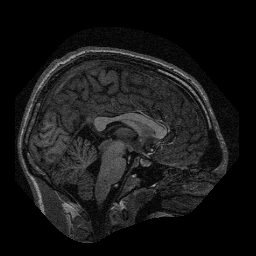

In [40]:
from IPython.display import display
import glob
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
#import tensorflow as tf


im_frame = Image.open("altered_test1.png")
#change to k-space
img_fft = fftshift(fftn(im_frame))
size_img = img_fft.shape
#np.random.uniform  , np.random.normal
#std = np.random.uniform(0.00, 0.06) * np.amax(img_fft.all())
std = np.random.uniform(0.000, 0.006) * np.amax(img_fft)
noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
img_ftt_noise = img_fft + noise # k-space
#revert from K-space to image
img_noise = ifftn(ifftshift(img_ftt_noise))
#################
np_image = np.array(im_frame)
np_noise = np.uint8(img_noise)

display(im_frame)

In [41]:
img_noise

array([[-22.02703804 -8.32275851j,   0.21022106+15.95377727j,
        -45.77466925 +4.76241547j, ...,  30.09081173+31.74708232j,
        -24.50454351-39.74759346j,  47.51827444 -1.42783307j],
       [-35.29290598 -4.60981996j,  74.23749615 -4.55388394j,
         13.61925215-36.57112395j, ...,  27.52957594+12.89683258j,
        -18.25368273+33.35836415j, -36.63246883 -0.64276454j],
       [  4.53545845+37.7153146j ,  28.01153018-12.1142334j ,
          5.65277916-17.27991605j, ...,  14.29768781+31.07813341j,
         29.774858  -14.79510819j,   4.61321909+11.60439169j],
       ...,
       [-13.95807491 +5.69613276j, -26.94062909+23.09330537j,
        -19.77751045+17.64784252j, ...,  57.62731532+41.41255003j,
         15.35140095+50.64026248j, -13.90175032+23.36052575j],
       [-37.35512111+19.68984383j, -54.68704303-32.03960558j,
         32.99362568+28.58056958j, ...,   6.96527859-65.70457731j,
         16.1751318  -2.40502614j,  11.69736879-42.58561386j],
       [-43.85329966-15.1166

In [42]:
result = to_tensor(np.array(im_frame)).unsqueeze(0)
result1 = to_tensor(np.uint8(img_noise)).unsqueeze(0)  
img_gt, img_und = result, result1


#need to perform np.reshape(img_gt, (256, 256))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [43]:
result = torch.from_numpy(np.array(im_frame))

In [44]:
result = torch.from_numpy(np.uint8(img_noise))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [45]:
np.array(im_frame).shape

(256, 256)

In [46]:
import torchvision.transforms as T
original = T.ToTensor()(np.array(im_frame)).unsqueeze(0)
testNoise = T.ToTensor()(np.uint8(img_noise)).unsqueeze(0) 
preprocess = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])
X = preprocess(Image.fromarray(np.uint8(img_noise)).convert('RGB'))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


In [47]:
testNoise.shape

torch.Size([1, 1, 256, 256])

In [48]:
X.shape

torch.Size([3, 224, 224])

In [49]:
X.squeeze(0)
X.shape

torch.Size([3, 224, 224])

In [50]:
X.unsqueeze(1)
X.shape

torch.Size([3, 224, 224])

In [51]:
img_gt = img_gt.numpy()

In [52]:
 print(type(img_gt))

<class 'numpy.ndarray'>


In [53]:
 print(img_gt.shape)

(1, 256, 256)


In [54]:
array = np.reshape(img_gt, (256, 256))

In [55]:
print(array.shape)

(256, 256)


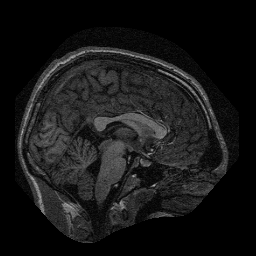

In [56]:
image1 = Image.fromarray(array).convert('RGB')
display(image1)

In [57]:
img_noise

array([[-22.02703804 -8.32275851j,   0.21022106+15.95377727j,
        -45.77466925 +4.76241547j, ...,  30.09081173+31.74708232j,
        -24.50454351-39.74759346j,  47.51827444 -1.42783307j],
       [-35.29290598 -4.60981996j,  74.23749615 -4.55388394j,
         13.61925215-36.57112395j, ...,  27.52957594+12.89683258j,
        -18.25368273+33.35836415j, -36.63246883 -0.64276454j],
       [  4.53545845+37.7153146j ,  28.01153018-12.1142334j ,
          5.65277916-17.27991605j, ...,  14.29768781+31.07813341j,
         29.774858  -14.79510819j,   4.61321909+11.60439169j],
       ...,
       [-13.95807491 +5.69613276j, -26.94062909+23.09330537j,
        -19.77751045+17.64784252j, ...,  57.62731532+41.41255003j,
         15.35140095+50.64026248j, -13.90175032+23.36052575j],
       [-37.35512111+19.68984383j, -54.68704303-32.03960558j,
         32.99362568+28.58056958j, ...,   6.96527859-65.70457731j,
         16.1751318  -2.40502614j,  11.69736879-42.58561386j],
       [-43.85329966-15.1166

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


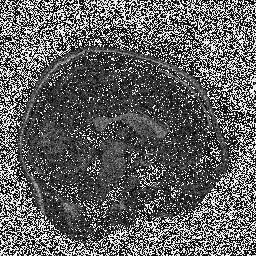

In [58]:
from IPython.display import display
from matplotlib import cm
image = Image.fromarray(np.uint8(img_noise)).convert('RGB')
display(image)

# The initial model, based on the AlexNet architecture

In [59]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64 ,64, kernel_size=3, padding=1),  # 320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 320/320
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # 320/320
            
            
        )

    def forward(self, x):
        x = self.features(x)
        return x

# RestNet

In [60]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        self.layer13 = self._layer(block,64,num_layers[3],stride=1)
        self.layer14 = self._layer(block,64,num_layers[3],stride=1)
        self.layer15 = self._layer(block,64,num_layers[3],stride=1)
        self.layer16 = self._layer(block,64,num_layers[3],stride=1)
        self.layer17 = self._layer(block,64,num_layers[3],stride=1)
        self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.layer17(x)
        x = self.layer18(x)
        x = self.conv2(x)

        return x

In [61]:
from skimage.metrics import structural_similarity as cmp_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [13]:
if __name__ == '__main__':
    
    data_path_train = 'matlab/images'
    data_path_val = 'matlab/images'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    
    acc = 4
    cen_fract = 0.08
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    lr = 1e-3
    
    network_4fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
    network_4fold.to('cuda:0') #move the model on the GPU
    mae_loss = nn.L1Loss().to('cuda:0')
    
    optimizer = optim.Adam(network_4fold.parameters(), lr=lr)
    fixed_train_set = []
    for val in data_list['train']:
        if val[2] > 5:
            fixed_train_set.append(val)
    #create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
    
    losses=[]
    mean_loss_list = []
    img_nr = 0
    for epoch in range(1):
        for iteration, sample in enumerate(train_loader):
            img_nr += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = network_4fold(img_und)       #feedforward


            loss = mae_loss(output, img_gt)

            optimizer.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer.step()     #update the weights
            mean_loss_list.append(loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
            if img_nr%20 == 0:
                print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
                mean_loss_list = []
            losses.append(loss.item() * img_gt.size(0))

OSError: Unable to open file (file signature not found)

In [ ]:
#L1 loss plot ofr the 4-fold data
plt.plot(losses)
plt.show()

In [ ]:
SSIM_improvement = []
SSIM_score = []
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    #image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_4fold(image)
    output = output.squeeze(1).cpu().detach().numpy()
    output_loss = torch.tensor(ssim(gt, output))
    image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    SSIM_improvement.append(output_loss.item()-image_loss.item())
    SSIM_score.append(output_loss.item())

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

In [26]:
if __name__ == '__main__':
    
    data_path_train = 'data/train'
    data_path_val = 'data/val'
    data_list = load_data_path(data_path_train, data_path_val)
    
    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    mae_loss = nn.L1Loss().to('cuda:0')
    #mae_loss = nn.L1Loss()
    lr = 3e-3
    #acc =8 , network_8fold
    network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
    network_8fold.to('cuda:0') #move the model on the GPU

    
    optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)
    fixed_train_set = []
    #for val in data_list['train']:
      #  print(f'val shape {val}')
      #  if val[2] > 5:
       #     fixed_train_set.append(val)
    #create data loader for training set. It applies same to validation set as well
    #train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
    
    losses2=[]
    mean_loss_list = []
    img_nr = 0
    for epoch in range(3):
        for iteration, sample in enumerate(train_loader):
            img_nr += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = network_8fold(img_und)      #feedforward

            loss = mae_loss(output, img_gt)

            optimizer2.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer2.step()     #update the weights
            mean_loss_list.append(loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
            if img_nr%20 == 0:
                print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
                mean_loss_list = []
            losses2.append(loss.item() * img_gt.size(0))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 1 3 3, but got 5-dimensional input of size [1, 1, 256, 256, 2] instead

In [ ]:
plt.plot(losses2)
plt.show()

In [ ]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    #image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
    output = output.squeeze(1).cpu().detach().numpy()
    output_loss = torch.tensor(ssim(gt, output))
    image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    SSIM_improvement.append(output_loss.item()-image_loss.item())
    SSIM_score.append(output_loss.item())

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

## save Model

In [ ]:
index = 1

In [ ]:
output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"

In [ ]:
#save model to S3 bucket or data
torch.save(network_8fold.state_dict(), output_dir)
#torch.save(network_8fold.state_dict(), './models/resnet18-model.pt')

## Load Model from saved model

In [ ]:
output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"

In [ ]:
#load model on GPU
device = torch.device("cuda")
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])

#model = model.to('cuda:0')
model.load_state_dict(torch.load(output_dir, map_location='cuda:0'))
#model.load_state_dict(torch.load('./models/resnet18-model.pt', map_location='cuda:0'))
model.to(device)
model.eval()

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(output_dir, map_location=device))
model.eval()

## Predict a single image

In [ ]:
model_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(model_dir, map_location=device))
model.eval()

In [ ]:
from PIL import Image

In [ ]:
file_dir = "/data/test/images/101.png"

In [ ]:
im_frame = Image.open(file_dir)
   
noise_im_frame = noise_and_kspace(im_frame)

img_gt= to_tensor(np.array(im_frame)).unsqueeze(0) #original image tensor form
img_noise = to_tensor(np.array(noise_im_frame)).unsqueeze(0) # noise image tensor form    
    


####################
#image = noise_image.unsqueeze(0) , no need to unsqueeze because it was not squeeze
t_noise_image = img_noise # k_noise numpy array
np_noise_image = np.reshape(t_noise_image.numpy(), (256, 256)) # image noise numpy array
im_noise = Image.fromarray(np_noise_image).convert('RGB')
im_noise.save("noise.png")

In [ ]:
from IPython.display import display
display(im_noise)

In [ ]:
from skimage.metrics import structural_similarity as cmp_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [ ]:
    #noise_image = noise_image.to('cuda:0')
    
img_gt = img_gt.numpy()
output = model(img_noise)
   # output = output.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).detach().numpy()   #image under numpy form
output_loss = torch.tensor(ssim(img_gt, output))  
image_loss = torch.tensor(ssim(img_gt, img_noise.squeeze(1).numpy()))
SSIM_improvement = (output_loss.item()-image_loss.item())
SSIM_score = output_loss.item()

In [ ]:
np_rescontruct_image = np.reshape(output, (256, 256))# image noise numpy array
im_reconstruct = Image.fromarray(np_rescontruct_image).convert('RGB')
im_reconstruct.save("testing/test.png") #for prediction values
im_reconstruct.save("pred1.png")